Hello, and welcome to the modeling segment of my project. My plans for this are as follows: 

1.) Find the model that best predicts the expected ridership.

2.) Find out what effects the ridership the most and try to make distinct groups using this information.

3.) With the distinct groups made, create a final suggested pricing model and any additional pricing schemes that would be beneficial.

And to start off, I need to find the model that best predicts the total ridercount, so lets jump right into that.

In [1]:
#I'll start off, as always, with an import window.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

#There are a lot of model types to try out with each having a lot more distinction within it's own category, so I'll choose
#a couple for base model testing for each before I do any hyperparameter tuning. Thus as I am taking more time in this 
#anyway, I'll just use a Grid Search for my hyperparameter tuning.
from sklearn.model_selection import GridSearchCV

#For the linear models I am trying out I'll go with a basic linear regression and a ridge regression
from sklearn.linear_model import LinearRegression, Ridge

#For the knn models I want to try out basic k neighbors and the radius neighbors regressors
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor

#For my ensemble methods I'll go with a Ada boost and random forest regressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

#And I also want to try out a neural network, so I'll use the multi-layer perceptron regressor.
from sklearn.neural_network import MLPRegressor

#And for analysis I need the mean squared error, so I'll get that real quick.
from sklearn.metrics import mean_squared_error, r2_score

#And I want to ignore the warnings, so I'll go ahead and use this.
import warnings
warnings.filterwarnings("ignore")

#I like the 538 style of graphs, so I'll set a statement to use them here.
plt.style.use('fivethirtyeight')

I think these 7 should be good enough te get an idea of how each of these out of the box performs before any hyperparametertuning is done. Now I'll set up a bit of code to run through all of these and return the r^2 and rmse as the metrics for analysis with rmse being the main metric and r^2 being used if needed. But first I have to get things ready.

In [2]:
#First I need to get the dataframes for the X and y training and testing sets back and ready for use.
X_tr = pd.read_csv('data/X_train.csv')
X_te = pd.read_csv('data/X_test.csv')
y_tr = pd.read_csv('data/y_train.csv')
y_te = pd.read_csv('data/y_test.csv')
print(len(X_tr), len(X_te))
print(len(y_tr), len(y_te))

13034 4345
13034 4345


In [3]:
y_tr

,cnt
0,85
1,194
2,317
3,33
4,307
...,...
13029,359
13030,812
13031,189
13032,100


In [4]:
X_tr

,holiday,workingday,temp,atemp,hum,windspeed,season_Spring,season_Summer,season_Winter,hr_1,...,hr_23,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Best,weathersit_Okay,weathersit_Worst
0,0,0,0.28,0.2727,0.45,0.2537,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0,1,0.92,0.8485,0.35,0.3582,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,0.72,0.6515,0.28,0.4627,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
3,0,1,0.36,0.3485,0.62,0.1940,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0.52,0.5000,0.39,0.3582,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13029,0,1,0.46,0.4545,0.88,0.0896,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
13030,0,1,0.66,0.6212,0.34,0.1343,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
13031,0,1,0.80,0.7273,0.43,0.2836,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
13032,0,1,0.24,0.1970,0.65,0.4179,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0


In [5]:
#Okay, it looks like everything transfered over okay. Now it's time to iterate through all the models I'm going to try and 
#see what works best.
models_dict = {
    'model_name' : ['Linear', 'Ridge', 'KNN', 'Radius Neighbors', 'AdaBoost', 'Random Forest', 'Multi-Layer Perceptron'],
    'model'      : [LinearRegression(), Ridge(), KNeighborsRegressor(), RadiusNeighborsRegressor(), AdaBoostRegressor(), RandomForestRegressor(), MLPRegressor()],
    #I'll put in placeholder values for now.
    'train_r2'   : [0, 1, 2, 3, 4, 5, 6],
    'test_r2'    : [0, 1, 2, 3, 4, 5, 6],
    'train_rmse' : [0, 1, 2, 3, 4, 5, 6],
    'test_rmse'  : [0, 1, 2, 3, 4, 5, 6],
    'time'       : [0, 1, 2, 3, 4, 5, 6]
}

In [6]:
for key, mod in models_dict.items():
    if key == 'model':
        for item in range(7):
            #Start timer
            start = time.time()
            
            #Assign the model for testing
            cur_mod = mod[item]
            cur_mod.fit(X_tr, y_tr)
            
            #Get the predictions
            y_tr_pred = cur_mod.predict(X_tr)
            y_te_pred = cur_mod.predict(X_te)
            
            #End the timer and put metrics into dictionary
            end = time.time()
            
            models_dict['train_r2'][item] = r2_score(y_tr, y_tr_pred)
            models_dict['test_r2'][item] = r2_score(y_te, y_te_pred)
            models_dict['train_rmse'][item] = mean_squared_error(y_tr, y_tr_pred, squared = False) 
            models_dict['test_rmse'][item] = mean_squared_error(y_te, y_te_pred, squared = False)
            models_dict['time'][item] = end - start

In [7]:
results_df = pd.DataFrame(models_dict)
results_df

,model_name,model,train_r2,test_r2,train_rmse,test_rmse,time
0,Linear,LinearRegression(),0.627916,6.245704e-01,111.049976,1.098780e+02,0.043496
1,Ridge,Ridge(),0.627916,6.244109e-01,111.049905,1.099014e+02,0.018978
2,KNN,KNeighborsRegressor(),0.852828,7.686555e-01,69.841021,8.625339e+01,4.504978
3,Radius Neighbors,RadiusNeighborsRegressor(),0.821844,-7.305967e+31,76.841959,1.532800e+18,2.215079
4,AdaBoost,"(DecisionTreeRegressor(max_depth=3, random_sta...",0.371221,3.626201e-01,144.360033,1.431679e+02,1.008274
5,Random Forest,"(DecisionTreeRegressor(max_features='auto', ra...",0.974020,8.224232e-01,29.343723,7.556831e+01,10.910859
6,Multi-Layer Perceptron,MLPRegressor(),0.811825,8.065430e-01,78.972959,7.887491e+01,15.670602


From a inital glance at things, it can be seen that some models are very bad and others are okay and could see imporvement. First and foremost, the radius neighbors performed very poorly out of the box. This could maybe be helped with hyperparameter tuning, but the KNN model also did not perform the best so I'm not sure if that would be to my favor. I want to compare the test rmse values with a bar graph, as the train values were more for a complete look. I'll also probably do the same for the r2 scores.

In [8]:
#First, I have to remove the radius neighbors from the dataset as it will make it hard to compare the other models with how
#off it is.
results_df.drop(3, axis = 0, inplace = True)
results_df

,model_name,model,train_r2,test_r2,train_rmse,test_rmse,time
0,Linear,LinearRegression(),0.627916,0.624570,111.049976,109.878036,0.043496
1,Ridge,Ridge(),0.627916,0.624411,111.049905,109.901374,0.018978
2,KNN,KNeighborsRegressor(),0.852828,0.768656,69.841021,86.253389,4.504978
4,AdaBoost,"(DecisionTreeRegressor(max_depth=3, random_sta...",0.371221,0.362620,144.360033,143.167946,1.008274
5,Random Forest,"(DecisionTreeRegressor(max_features='auto', ra...",0.974020,0.822423,29.343723,75.568310,10.910859
6,Multi-Layer Perceptron,MLPRegressor(),0.811825,0.806543,78.972959,78.874909,15.670602


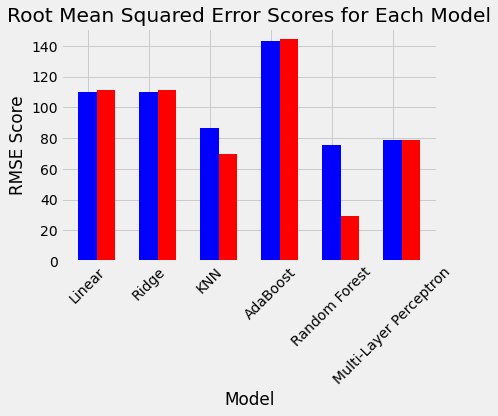

In [9]:
bar_w = 0.3
bar_pos = list(range(1, 7))
bar_pos_2 = [x + bar_w for x in bar_pos]
_ = plt.bar(bar_pos, results_df['test_rmse'], color = 'blue', label = 'Test Score', width = bar_w)
_ = plt.bar(bar_pos_2, results_df['train_rmse'], color = 'red', label = 'Train Score', width = bar_w)
_ = plt.xticks(bar_pos, results_df['model_name'], rotation = 45)
_ = plt.xlabel('Model')
_ = plt.ylabel('RMSE Score')
_ = plt.title('Root Mean Squared Error Scores for Each Model')
plt.show()

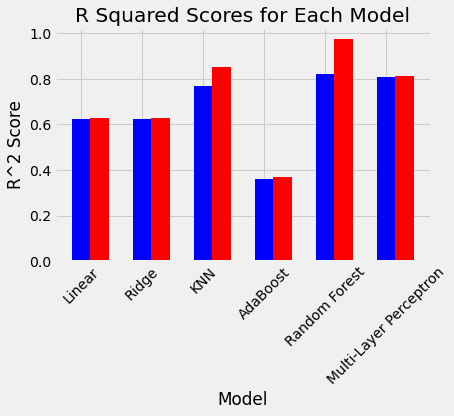

In [10]:
_ = plt.bar(bar_pos, results_df['test_r2'], color = 'blue', label = 'Test Score', width = bar_w)
_ = plt.bar(bar_pos_2, results_df['train_r2'], color = 'red', label = 'Train Score', width = bar_w)
_ = plt.xticks(bar_pos, results_df['model_name'], rotation = 45)
_ = plt.xlabel('Model')
_ = plt.ylabel('R^2 Score')
_ = plt.title('R Squared Scores for Each Model')
plt.show()

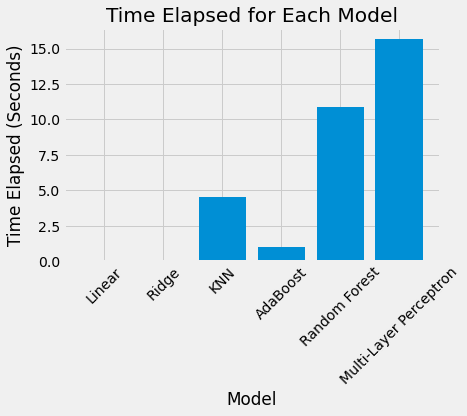

In [11]:
#And I also want to see the time used. This won't be the key metric, but I think it is nice to know.
_ = plt.bar(bar_pos, results_df['time'])
_ = plt.xticks(bar_pos, results_df['model_name'], rotation = 45)
_ = plt.xlabel('Model')
_ = plt.ylabel('Time Elapsed (Seconds)')
_ = plt.title('Time Elapsed for Each Model')
plt.show()

Okay, so all of the results are logical, and I'll go over why each thing makes sense. First, the similarity between the ridge and linear regressions was due to the fact that there are mostly the same, with ridge regression being used to keep overfitting to certian highly correlative features, which shows that overfitting to one single feature was not really that large of a problem. Additionally the Adaboost model did not perform well, and while this could be due to hyperparameter selection I still think working with that model further would not yeild that much of a positive result. The model that I think has the best opprotunity for imporvement is the Random Forest, as while it is noticably overfit, it still best describes the test set and wouldn't incur as much computation time as doing the hyperparameter tuning with the mulit-layer perception model. That said, lets jump into the hyperparameter tuning to define the best model. 

In [12]:
#First, lets define the grid so we can use the GridSearchCV that was imported earlier.
start = time.time()
rf_mod = RandomForestRegressor()
rf_params = {'n_estimators'      : [10, 25, 50, 100, 250, 500],
             'max_features'      : ['auto', 'sqrt', 'log2'],
             'bootstrap'         : [True, False],
             'min_samples_split' : [2, 4, 8, 10, 20]
            }
rf_grid = GridSearchCV(estimator = rf_mod, param_grid = rf_params, n_jobs = -1)
rf_grid.fit(X_tr, y_tr)
end = time.time()
print(end - start)

1300.331799030304


In [16]:
#Well, that took a while (a bit over 26 minutes). Lets see if there was much imporvement over the inital run.
print('Best Params            :', rf_grid.best_estimator_)
rf_train_r2_best = rf_grid.best_score_
print('Best Score             :', rf_train_r2_best)

rf_y_pred = rf_grid.predict(X_te)
rf_test_r2 = r2_score(y_te, rf_y_pred)
print('On Test Data R^2       :', rf_test_r2)

rf_y_tr_pred = rf_grid.predict(X_tr)
rf_tr_r2 = r2_score(y_tr, rf_y_tr_pred)
print('On Training Data R^2   :', rf_tr_r2)

rf_rmse = mean_squared_error(y_te, rf_y_pred, squared = False)
print('Root Mean Squared Error:', rf_rmse)

Best Params            : RandomForestRegressor(min_samples_split=8, n_estimators=500)
Best Score             : 0.8142407601050108
On Test Data R^2       : 0.8283934311255753
On Training Data R^2   : 0.9362283472636821
Root Mean Squared Error: 74.28712884364856


In [19]:
results_df[results_df['model_name'] == 'Random Forest']

,model_name,model,train_r2,test_r2,train_rmse,test_rmse,time
5,Random Forest,"(DecisionTreeRegressor(max_features='auto', ra...",0.97402,0.822423,29.343723,75.56831,10.910859


In [26]:
#Well, I feel comfortable in the model I have, so I'll assign it to the fin_mod
fin_mod = RandomForestRegressor(min_samples_split = 8, n_estimators = 500)
fin_mod.fit(X_tr, y_tr)

RandomForestRegressor(min_samples_split=8, n_estimators=500)

In [28]:
features = list(X_tr.columns.values)
important = np.sort(list(fin_mod.feature_importances_))
imp_table = pd.DataFrame(list(zip(features, important)), columns =['Features', 'Importance scores'])

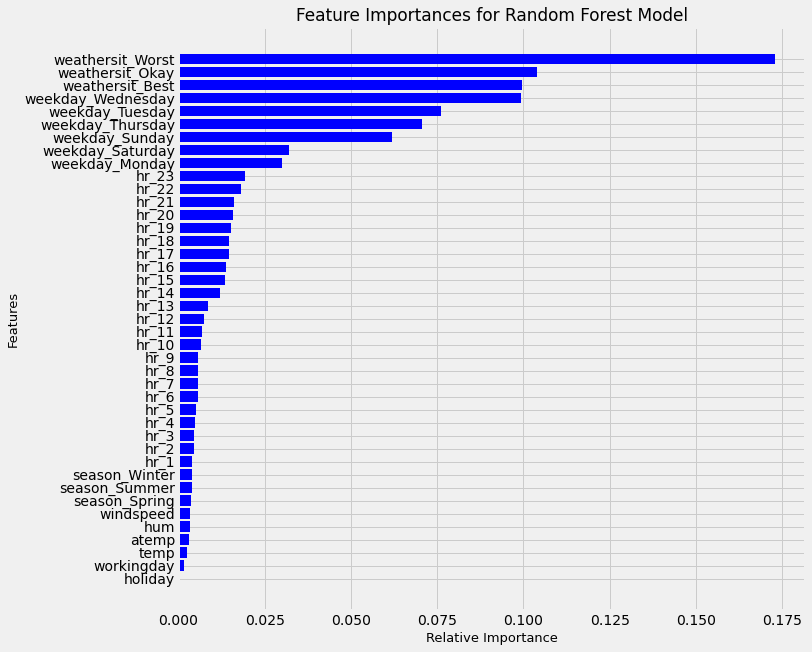

In [33]:
#Okay, it looks like that mitigated the overfitting a bit and also helped increase the accuracy (not by much though). While 
#I could try some additional hyperparameter tuning, increasing the n_estimators would increase the training time by quite a
#bit and I already feel comfortable with the results of this. Now I want to figure out what features effect this model the
#most.
index = list(range(len(X_tr.columns)))
_ = plt.figure(figsize=(10, 10))
_ = plt.barh(index, important, align='center',color='b')
_ = plt.xlabel('Relative Importance',fontsize = 13)
_ = plt.ylabel('Features',fontsize = 13)
_ = plt.yticks(index, features)
_ = plt.title('Feature Importances for Random Forest Model',fontsize = 17)
plt.savefig("rfimportance.png")
plt.show()

In [54]:
#Well, I know that I have some very deep and complex trees in a very large forest, so vizualizing them in a traditional way
#will be difficult to say the least. Instead I will do what I did on the first project and look at the expected difference 
#in outcome where the only difference is the one feature.
y_te[(y_te['cnt'] >= np.percentile(y_te['cnt'], 25)) & (y_te['cnt'] <= np.percentile(y_te['cnt'], 75))]

,cnt
1,88
11,89
16,188
21,161
23,84
...,...
4338,137
4339,190
4341,181
4342,88


In [84]:
#After seeing what rows are in the middle 50%, I'll choose the first one as a comparison row and make the other ones based
#off that one to see the expected difference under a varierty of situations.
trial_X_default = X_te.iloc[[1]]
trial_y_default = y_te.iloc[[1]]
#I won't be looking at the hours for now.
#For the inital values, it is hour 20 on a monday with best weather_sit
trial_df = {
    'trial_no' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'trial_diff' : ['original(mon-best_w)','wsit_okay', 'wsit_bad', 'wsit_worst', 'wd_wed', 'wd_tue', 'wd_thurs', 'wd_sun', 'wd_sat', 'wd_fri'],
    'predicted' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'diff_of_p' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
}

In [65]:
trial_X_default.columns

Index(['holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'season_Spring', 'season_Summer', 'season_Winter', 'hr_1', 'hr_2',
       'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10',
       'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18',
       'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'weathersit_Best',
       'weathersit_Okay', 'weathersit_Worst'],
      dtype='object')

In [63]:
trial_X_default.values

array([[1.    , 0.    , 0.24  , 0.2273, 0.41  , 0.2239, 0.    , 0.    ,
        1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.    ,
        1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 1.    , 0.    ,
        0.    ]])

In [87]:
#FIrst the different weather condiditons
trial_0 = [[1.    , 0.    , 0.24  , 0.2273, 0.41  , 0.2239, 0.    , 0.    ,
        1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.    ,
        1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 1.    , 0.    ,
        0.    ]]
trial_1 = [[1.    , 0.    , 0.24  , 0.2273, 0.41  , 0.2239, 0.    , 0.    ,
        1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.    ,
        1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 1.    ,
        0.    ]]
trial_2 = [[1.    , 0.    , 0.24  , 0.2273, 0.41  , 0.2239, 0.    , 0.    ,
        1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.    ,
        1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    ]]
trial_3 = [[1.    , 0.    , 0.24  , 0.2273, 0.41  , 0.2239, 0.    , 0.    ,
        1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.    ,
        1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        1.    ]]
#And now for the days.
trial_4 = [[1.    , 0.    , 0.24  , 0.2273, 0.41  , 0.2239, 0.    , 0.    ,
        1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 1.    , 1.    , 0.    ,
        0.    ]]
trial_5 = [[1.    , 0.    , 0.24  , 0.2273, 0.41  , 0.2239, 0.    , 0.    ,
        1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 1.    , 0.    , 1.    , 0.    ,
        0.    ]]
trial_6 = [[1.    , 0.    , 0.24  , 0.2273, 0.41  , 0.2239, 0.    , 0.    ,
        1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 1.    , 0.    ,
        0.    ]]
trial_7 = [[1.    , 0.    , 0.24  , 0.2273, 0.41  , 0.2239, 0.    , 0.    ,
        1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.    ,
        1.    , 0.    , 1.    , 0.    , 0.    , 0.    , 1.    , 0.    ,
        0.    ]]
trial_8 = [[1.    , 0.    , 0.24  , 0.2273, 0.41  , 0.2239, 0.    , 0.    ,
        1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.    ,
        0.    , 1.    , 0.    , 0.    , 0.    , 0.    , 1.    , 0.    ,
        0.    ]]
trial_9 = [[1.    , 0.    , 0.24  , 0.2273, 0.41  , 0.2239, 0.    , 0.    ,
        1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 1.    , 0.    ,
        0.    ]]
#Now put these into a list for iteration.
trials_list = [trial_0, trial_1, trial_2, trial_3, trial_4, trial_5, trial_6, trial_7, trial_8, trial_9]

In [88]:
#And make a for loop to go over each trial and return to the dictionary the relevant information.
set_num = 0
for item in trials_list:
    pred = fin_mod.predict(item)
    trial_df['predicted'][set_num] = pred
    trial_df['diff_of_p'][set_num] = pred - trial_y_default
    set_num += 1

In [89]:
trials_df = pd.DataFrame(trial_df)
trials_df

,trial_no,trial_diff,predicted,diff_of_p
0,0,original(mon-best_w),[87.23104787810232],[-0.7689521218976836]
1,1,wsit_okay,[94.39800768594151],[6.398007685941508]
2,2,wsit_bad,[90.86655004913388],[2.8665500491338776]
3,3,wsit_worst,[90.86655004913388],[2.8665500491338776]
4,4,wd_wed,[89.59858772159215],[1.5985877215921533]
5,5,wd_tue,[89.64562004155974],[1.645620041559738]
6,6,wd_thurs,[93.82697562355942],[5.82697562355942]
7,7,wd_sun,[86.7186272542817],[-1.2813727457183006]
8,8,wd_sat,[91.8863808340353],[3.886380834035293]
9,9,wd_fri,[87.73779957640402],[-0.26220042359598494]


In [90]:
#I know that the peak time for the service is 5pm, so I want to see what the expected difference would be here 
trial_peak_time = [[1.    , 0.    , 0.24  , 0.2273, 0.41  , 0.2239, 0.    , 0.    ,
        1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 1.    , 0.    ,
        0.    ]]
trial_pred_5pm = fin_mod.predict(trial_peak_time)
print('5pm all things same outcome:', trial_pred_5pm)
print('8pm original prediciton:', 87.23104787810232)

5pm all things same outcome: [105.7223205]
8pm original prediciton: 87.23104787810232


Okay, it looks like the expected difference from these categories is not that different. I had a feeling that the reason why the scores were all relativly close was because the main thing that changes the outcome more drasticly was the time of day, and I now know that to be somewhat true. With that, I feel like I know enough about this model to say that it has a pretty good understanding of what causes changes in the user ridership. With this knowlege I will try to leverage this model to the best of my ability to predict the total ridership before a given hour and set the price into 1 of 3 pricing groups based off the expected ridership for that given time.

In [97]:
#I know that this is only the test data, but to find my cutoff points I'll be using 33 and 66 percentiles for the different
#pricing groups, and while this may be my final decision I will probably bring up other pricing schemes in my final paper.
#Also, for this, I'll be basing my prices based off the predicted values and not the known ones.
y_te_pred = fin_mod.predict(X_te)
print(round(np.percentile(y_te_pred, 33)))
print(round(np.percentile(y_te_pred, 66)))
print(y_te_pred.max())
print(y_te_pred.min())

91
219
787.5972551214264
1.8738123347240987


In [99]:
#Okay, now that I have my cutoff points, I'll predict how much this model would make as opposed to the assumed flat pricing
#The inital model isn't necessarily a flat price but as none was given I'll just assign a flat price of $4 for now as that 
#is what NYC city bike charges as of now and apply a $0.50 discount for the predicted low value times (bottom 1/3rd), the 
#same $4 for the middle 1/3rd and a $0.50 price increase for the top 1/3rd.
pred_prices = []
for val in y_te_pred:
    if val <= 91:
        pred_prices.append(3.50)
    elif (val > 91) and (val < 219):
        pred_prices.append(4.00)
    else:
        pred_prices.append(4.50)

In [100]:
#And as we already know the ridership for these times, we can predict the revnue made from a flat system and from the varied
#system.
y_te['flat'] = 4.00
y_te['varied'] = pred_prices
y_te

,cnt,flat,varied
0,425,4.0,4.5
1,88,4.0,3.5
2,4,4.0,3.5
3,526,4.0,4.5
4,13,4.0,3.5
...,...,...,...
4340,21,4.0,3.5
4341,181,4.0,4.0
4342,88,4.0,4.0
4343,14,4.0,3.5


In [105]:
#And now to see the results.
flat_tot = 0
varied_tot = 0
for index, row in y_te.iterrows():
    flat_tot += row['flat'] * row['cnt']
    varied_tot += row['varied'] * row['cnt']
print('Total Made in 4345 hrs (~181 days) under Flat Rate  :', flat_tot)
print('Total Made in 4345 hrs (~181 days) under Varied Rate:', varied_tot)
print('Total Extra Made Under New Pricing Model            :', varied_tot - flat_tot)
print('Expected Percent increase Under New Pricing Model   :', round((((varied_tot - flat_tot) / (flat_tot)) * 100), 2), '%')

Total Made in 4345 hrs (~181 days) under Flat Rate  : 3245084.0
Total Made in 4345 hrs (~181 days) under Varied Rate: 3498216.5
Total Extra Made Under New Pricing Model            : 253132.5
Expected Percent increase Under New Pricing Model   : 7.8 %


I'll try to be quick here as the final write-up is more where I plan to share my thoughts. For one, I definitely think that this pricing model change would work well even accepting some differences after implementing this pricing scheme. The plan to move forward from here for the performance of this varied pricing system would revolve around developing a strategy to automatically collect relevant information about the predicted situations for the next hour and make a prediction on the total amount of people using the system and assign the price for the next hour based off of that prediction. I'll be the first to admit that there may be some things that I missed or some lapses in judgment in how I implemented this, but even then I think you could expect high returns if this pricing system was used. Thanks for looking through my work and you’ll hear from me again in the technical review paper.